Imports and setup some variables

In [3]:
import csv
from itertools import permutations
from tabulate import tabulate
from tree_from_assoc_rules import __fetch_assoc_rule, __find_unique
import time
import numpy as np

hotel_name = "Baan Laimai Beach Resort & Spa"

Load possible values into variable `possible_values`

In [4]:
possible_values = []
file = open('./possible_values.csv')

for line in file.readlines():
    possible_values.append(line.rstrip())
file.close();

Remove some factors to reduce number of possibility in this experiment

In [5]:
# Remove 3 types of parameters: country, room_type, stay
# Remains: length_of_stay and review_group
filtered_factors = list(filter(lambda x : not x.startswith("country") and not x.startswith("room_type") and not x.startswith("stay"), possible_values))

# Use it all!
# filtered_factors = possible_values
print(filtered_factors)

['length_of_stay:1-7', 'length_of_stay:8-15', 'length_of_stay:>15', 'review_group:Business', 'review_group:Couple', 'review_group:Family', 'review_group:Group', 'review_group:Solo']


Do permutation of factors with range of 2 for finding association rules

In [6]:
perm = [list(x) for x in permutations(filtered_factors, 2) ]
headers = ["Factor 1", "Factor 2", "Confidence", "Lift"]
print(tabulate(list(perm), headers=headers))

Factor 1               Factor 2
---------------------  ---------------------
length_of_stay:1-7     length_of_stay:8-15
length_of_stay:1-7     length_of_stay:>15
length_of_stay:1-7     review_group:Business
length_of_stay:1-7     review_group:Couple
length_of_stay:1-7     review_group:Family
length_of_stay:1-7     review_group:Group
length_of_stay:1-7     review_group:Solo
length_of_stay:8-15    length_of_stay:1-7
length_of_stay:8-15    length_of_stay:>15
length_of_stay:8-15    review_group:Business
length_of_stay:8-15    review_group:Couple
length_of_stay:8-15    review_group:Family
length_of_stay:8-15    review_group:Group
length_of_stay:8-15    review_group:Solo
length_of_stay:>15     length_of_stay:1-7
length_of_stay:>15     length_of_stay:8-15
length_of_stay:>15     review_group:Business
length_of_stay:>15     review_group:Couple
length_of_stay:>15     review_group:Family
length_of_stay:>15     review_group:Group
length_of_stay:>15     review_group:Solo
review_group:Business  leng

Match each pair of factors with association rule confidence and lift

In [7]:
for pair in perm:
    rules = __fetch_assoc_rule(pair[0], pair[1], hotel_name=hotel_name) # rule = {"confidence": 1.0, "lift": 0.6}
    found_rules_count = len(rules)
    if found_rules_count > 0:
        pair.append(rules[0]["confidence"] or 0)
        pair.append(rules[0]["lift"] or 0)
print(tabulate(list(perm), headers=headers))

Factor 1               Factor 2                 Confidence      Lift
---------------------  ---------------------  ------------  --------
length_of_stay:1-7     length_of_stay:8-15
length_of_stay:1-7     length_of_stay:>15
length_of_stay:1-7     review_group:Business
length_of_stay:1-7     review_group:Couple        0.666667   1.61905
length_of_stay:1-7     review_group:Family        0.666667   3.2381
length_of_stay:1-7     review_group:Group         1          3.77778
length_of_stay:1-7     review_group:Solo          1         11.3333
length_of_stay:8-15    length_of_stay:1-7
length_of_stay:8-15    length_of_stay:>15
length_of_stay:8-15    review_group:Business
length_of_stay:8-15    review_group:Couple        1          2.42857
length_of_stay:8-15    review_group:Family
length_of_stay:8-15    review_group:Group         1          3.77778
length_of_stay:8-15    review_group:Solo
length_of_stay:>15     length_of_stay:1-7
length_of_stay:>15     length_of_stay:8-15
length_of_stay:>15    

Create transition matrix of 2 types
 - transition_matrix = transition matrix with only confidence value
 - transition_matrix_confidence_lift = transition matrix for print, having label and pair of confidence and lift

In [8]:
factors_len = len(filtered_factors)
transition_matrix = []
transition_matrix_confidence_lift = []

# Calculation of transition_matrix
for i in range(factors_len):
    row = []
    for j in range(factors_len):
        f1 = filtered_factors[i]
        f2 = filtered_factors[j]
        rule = next((x[2] for x in list(perm) if x[0] == f1 and x[1] == f2 and len(x) > 2), 0)
        row.append(rule)
    transition_matrix.append(row)

# Calculation of transition_matrix_confidence_lift
for i in range(factors_len):
    row = []
    for j in range(factors_len + 1):
        if j == 0:
            row.append(filtered_factors[i])
        else:
            f1 = filtered_factors[i]
            f2 = filtered_factors[j-1]
            rule = next(((x[2], x[3]) for x in list(perm) if x[0] == f1 and x[1] == f2 and len(x) > 2), (0,0))
            row.append(rule)
    transition_matrix_confidence_lift.append(row)

Writing transition_matrix_confidence_lift to file for further inspection

In [9]:
# Write transition_matrix_confidence_lift to file
timestr = time.strftime("%Y%m%d-%H%M%S")
f = open("out"+timestr+".tab","w")
f.write(tabulate(list(transition_matrix_confidence_lift), headers=[""] + filtered_factors, tablefmt="plain"))
f.close()

Trying to plot state graph from transition matrix, which not quite work.

{'s0': 'C0', 's1': 'C1', 's2': 'C2', 's3': 'C3', 's4': 'C4', 's5': 'C5', 's6': 'C6', 's7': 'C7'}


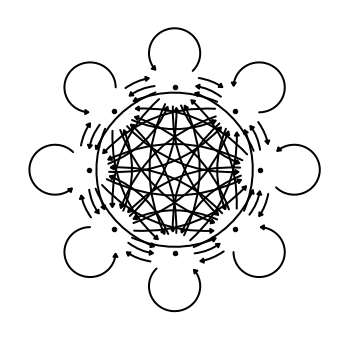

In [10]:
from hmmviz import TransGraph
import pandas as pd
import matplotlib.pyplot as plt

colors = {f's{i}': f'C{i}' for i in range(len(filtered_factors))}
print(colors)
graph = TransGraph.from_array(transition_matrix, filtered_factors)
plt.figure(figsize=(6, 6))
graph.draw(edgecolors=colors, nodecolors=colors, nodelabels=False, edgewidths=2)
plt.show()

In this block, we will simulate user's selected weight choice with
    length_of_stay = 0.8 and review_group = 0.2
of filtered_factors = ['length_of_stay:1-7', 'length_of_stay:8-15', 'length_of_stay:>15', 'review_group:Business', 'review_group:Couple', 'review_group:Family', 'review_group:Group', 'review_group:Solo']

So, we can create initial state array of Makov chain as
    [0.8/3, 0.8/3, 0.8/3, 0.2/5, 0.2/5, 0.2/5, 0.2/5, 0.2/5]

Then we can produce dot product of initial_state x transition_matrix as:
    [0.09863014, 0.02465753, 0, 0, 0.2739726, 0.10958904, 0.32876712, 0.16438356]

What we can tell of this result??
 - Don't know

In [11]:
initial_state_array = [0.8/3, 0.8/3, 0.8/3, 0.2/5, 0.2/5, 0.2/5, 0.2/5, 0.2/5]
initial_state = np.array(initial_state_array)
transition_prob = np.array(transition_matrix)
dot = initial_state.dot(transition_prob)
print(dot)
dot_norm_val = sum(dot)
norm_prob = dot/dot_norm_val
print(norm_prob)
# print(norm_prob)

p = [[v, norm_prob[filtered_factors.index(v)], str(round(norm_prob[filtered_factors.index(v)] * 100,2)) + "%"] for v in filtered_factors]
print(tabulate(p))

[0.16       0.04       0.         0.         0.44444444 0.17777778
 0.53333333 0.26666667]
[0.09863014 0.02465753 0.         0.         0.2739726  0.10958904
 0.32876712 0.16438356]
---------------------  ---------  ------
length_of_stay:1-7     0.0986301  9.86%
length_of_stay:8-15    0.0246575  2.47%
length_of_stay:>15     0          0.0%
review_group:Business  0          0.0%
review_group:Couple    0.273973   27.4%
review_group:Family    0.109589   10.96%
review_group:Group     0.328767   32.88%
review_group:Solo      0.164384   16.44%
---------------------  ---------  ------
